<a href="https://colab.research.google.com/github/feeblefruits/neural_net_blur_detection/blob/master/cnn_blur_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialise GPU
*Runtime > Change runtime type > GPU*

# Setup data dir
Kaggle blur dataset is used - can be found [here](https://www.kaggle.com/kwentar/blur-dataset?)

Add Kaggle API key to root

In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files

In [3]:
# add kaggle.json from local to collab dir

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p /root/.kaggle

In [0]:
!mv kaggle.json /root/.kaggle

In [0]:
!chmod 600 /root/.kaggle/

Download dataset and unzip

In [7]:
!kaggle datasets download -d kwentar/blur-dataset

blur-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import os
import zipfile

local_zip = 'blur-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/blur-dataset')
zip_ref.close()

In [9]:
!ls

blur_1.jpg
blur_2.jpeg
blur_3.jpeg
blur_4.jpg
blur_5.jpeg
blur-dataset
blur-dataset.zip
clear_1.jpeg
clear_3.jpg
clear_5.jpeg
clear_6.jpeg
clear.jpeg
combined_blur_data
datasets_270005_579020_defocused_blurred_103_HUAWEI-P20_F.jpg
datasets_270005_579020_defocused_blurred_108_XIAOMI-MI8-SE_F.jpg
datasets_270005_579020_defocused_blurred_111_IPHONE-7_F.jpeg
datasets_270005_579020_defocused_blurred_112_NIKON-D3400-35MM_F.jpeg
datasets_270005_579020_defocused_blurred_115_NIKON-D3400-35MM_F.jpeg
datasets_270005_579020_defocused_blurred_124_HONOR-7X_F.jpg
datasets_270005_579020_sharp_106_NIKON-D3400-35MM_S.jpeg
datasets_270005_579020_sharp_107_XIAOMI-MI8-SE_S.jpg
datasets_270005_579020_sharp_10_ASUS-ZENFONE-LIVE-ZB501KL_S.jpg
datasets_270005_579020_sharp_113_SAMSUNG-GALAXY-A5_S.jpg
datasets_270005_579020_sharp_119_HONOR-7X_S.jpg
horse_2.jpeg
horse.jpeg
sample_data


In [10]:
!mkdir /content/combined_blur_data

mkdir: cannot create directory ‘/content/combined_blur_data’: File exists


In [0]:
!mv /content/blur-dataset/motion_blurred/*.jpg /content/blur-dataset/defocused_blurred



Add sharp and defocused folders under dir combined_blur_data


In [13]:
!mv /content/blur-dataset/defocused_blurred /content/blur-dataset/sharp /content/combined_blur_data

mv: cannot move '/content/blur-dataset/defocused_blurred' to '/content/combined_blur_data/defocused_blurred': Directory not empty
mv: cannot move '/content/blur-dataset/sharp' to '/content/combined_blur_data/sharp': Directory not empty


# Explore images

Check images names and length

In [15]:
training_data_dir = os.path.join('/content/combined_blur_data')

sharp_data_dir = os.path.join('/content/combined_blur_data/sharp')

defocused_data_dir = os.path.join('/content/combined_blur_data/defocused_blurred')

sharp_data_names = os.listdir(sharp_data_dir)
print(sharp_data_names[:10])

defocused_data_names = os.listdir(defocused_data_dir)
print(defocused_data_names[:10])

['274_NIKON-D3400-18-55MM_S.JPG', '175_IPHONE-SE_S.jpg', '318_HONOR-7C_S.jpg', '304_SAMSUNG-GALAXY-J7_S.jpg', '145_NIKON-D3400-18-55MM_S.JPG', '259_XIAOMI-REDMI-7_S.jpg', '246_HONOR-9_S.jpg', '30_HONOR-8X_S.jpg', '5_XIAOMI-PROCOFONE-F1_S.jpg', '51_IPHONE-SE_S.jpg']
['9_HUAWEI-P20_F.jpg', '92_IPHONE-7_F.jpeg', '181_HONOR-10_F.jpg', '70_HONOR-8X_M.jpg', '326_XIAOMI-PROCOFONE-F1_M.jpg', '342_XIAOMI-PROCOFONE-F1_M.jpg', '3_HUAWEI-NOVA-LITE_M.jpg', '30_HONOR-8X_M.jpg', '176_HONOR-7X_F.jpg', '15_HONOR-7C_F.jpg']


In [16]:
print('total sharp images:', len(os.listdir(sharp_data_dir)))
print('total defocused images:', len(os.listdir(defocused_data_dir)))

total sharp images: 350
total defocused images: 596


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

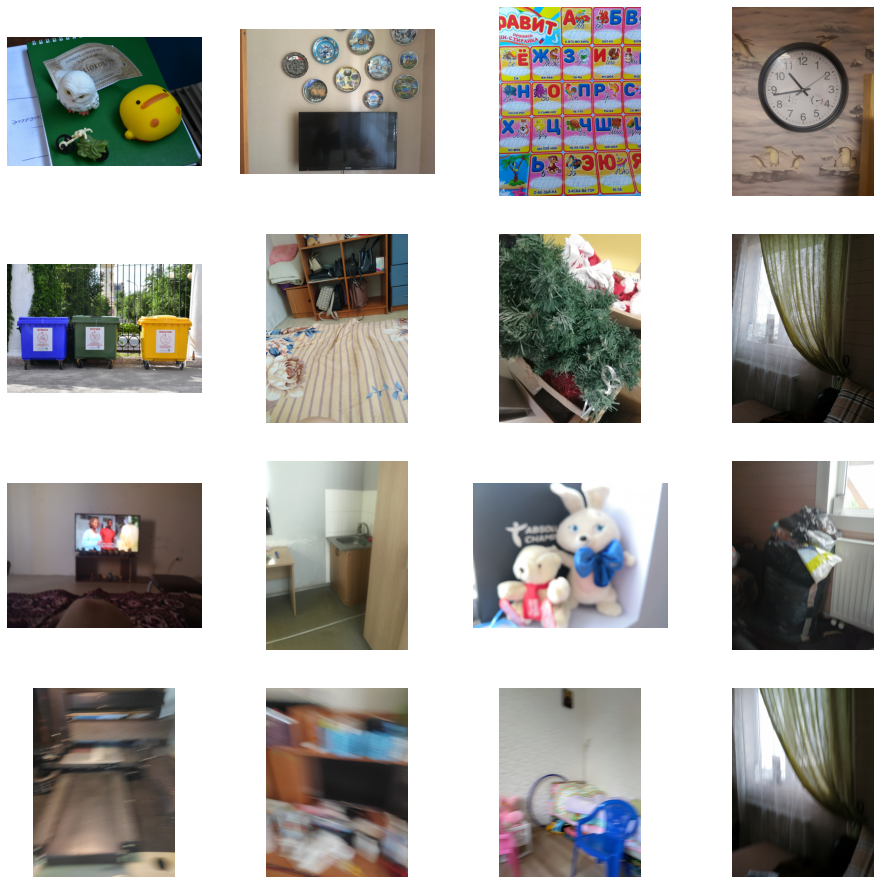

In [18]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_sharp_pix = [os.path.join(sharp_data_dir, fname) 
                for fname in sharp_data_names[pic_index-8:pic_index]]
next_defocused_pix = [os.path.join(defocused_data_dir, fname) 
                for fname in defocused_data_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_sharp_pix + next_defocused_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Initialise Tensorflow model

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [21]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

# Preprocess images

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255,
                                   validation_split=0.2)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        training_data_dir,  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='training')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = train_datagen.flow_from_directory(
        training_data_dir,  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='validation')


Found 757 images belonging to 2 classes.
Found 189 images belonging to 2 classes.


# Start training

In [28]:
callbacks = myCallback()

history = model.fit(
      train_generator,
      validation_data = validation_generator,  
      epochs=30,
      # steps_per_epoch=3, # steps rule of thumb amount of items divide by batch size
      # validation_steps=3,
      verbose=1,
      callbacks=[callbacks])

Epoch 1/30
6/6 [==============================] - 37s 6s/step - loss: 9.7386 - accuracy: 0.4571 - val_loss: 0.6741 - val_accuracy: 0.4762
Epoch 2/30
6/6 [==============================] - 37s 6s/step - loss: 0.6394 - accuracy: 0.6288 - val_loss: 0.6047 - val_accuracy: 0.7090
Epoch 3/30
6/6 [==============================] - 37s 6s/step - loss: 0.6655 - accuracy: 0.6948 - val_loss: 0.5059 - val_accuracy: 0.7989
Epoch 4/30
6/6 [==============================] - 37s 6s/step - loss: 0.6009 - accuracy: 0.7239 - val_loss: 0.4998 - val_accuracy: 0.8042
Epoch 5/30
6/6 [==============================] - 37s 6s/step - loss: 0.3987 - accuracy: 0.8705 - val_loss: 0.3132 - val_accuracy: 0.8889
Epoch 6/30
6/6 [==============================] - 38s 6s/step - loss: 0.7843 - accuracy: 0.8058 - val_loss: 0.3581 - val_accuracy: 0.8730
Epoch 7/30
6/6 [==============================] - 38s 6s/step - loss: 0.5439 - accuracy: 0.7596 - val_loss: 0.3654 - val_accuracy: 0.8889
Epoch 8/30
6/6 [==================

# Sanity check prediction with uploaded sample images

In [29]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = x / 255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a sharp")
  else:
    print(fn + " is a defocused")
 

Using TensorFlow backend.


Saving clear_6.jpeg to clear_6 (1).jpeg
Saving clear_5.jpeg to clear_5 (1).jpeg
Saving clear_3.jpg to clear_3 (1).jpg
Saving clear_1.jpeg to clear_1 (1).jpeg
Saving clear.jpeg to clear (1).jpeg
Saving blur_5.jpeg to blur_5 (1).jpeg
Saving blur_4.jpg to blur_4 (1).jpg
Saving blur_3.jpeg to blur_3 (1).jpeg
Saving blur_2.jpeg to blur_2 (1).jpeg
[1.5906791e-06]
clear_6.jpeg is a defocused
[0.99987185]
clear_5.jpeg is a sharp
[0.94782794]
clear_3.jpg is a sharp
[0.9924225]
clear_1.jpeg is a sharp
[0.98833686]
clear.jpeg is a sharp
[0.00882492]
blur_5.jpeg is a defocused
[0.06194505]
blur_4.jpg is a defocused
[0.02353378]
blur_3.jpeg is a defocused
[0.00501776]
blur_2.jpeg is a defocused


## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)